# Water management

We will control a dam responsible for dispatching water downstream, as well as avoid flooding in the region. This environment is modelled as a one-dimensional, continuous state, representing the amount of water present in the reservoir. This is subject to change, depending on factors such as rain.

At each timestep, the dam can release a specified water amount (a one-dimensional, continuous action).

The dam is responsible with supplying water, and needs to meet the water demand. At the same time, it should be careful not to hold too much water, as this increases the risk of flooding upstream.

These objectives are conflicting, since the inflow of water is on average insufficient to cope with the water demand. In order to increase the change of meeting future demand, the reservoir needs to be filled, thus increasing the risk of flooding upstream.

## Multi-objective Natural Evolution Strategies ##

With an unknown utility function, that can be non-linear, we want to propose a set of alternatives to the decision makers, by approximating the Pareto-front. Since we have no prior information about the preferences of the decision makers, we make no assumptions about the utility function.

The algorithm that will be used to approximate the coverage set is Multi-objective Natural Evolution Strategies (MONES). In essence, a parametric policy is used, where each parameter is represented by a Gaussian distribution. Sampling these distributions will result in an executable policy that can be applied on our environment. MONES will optimize the mean and standard-deviation of each parameter such that, each time we sample from them, we will have a policy that leads to a different point on the Pareto front.

MONES is an iterative process, that repeats 3 steps:

1. sample a population of policies from our parameters, and execute them on the environment
2. evaluate the quality of these policies using an indicator metric
3. perform a gradient step that improves this indicator, using the natural gradient

Our policy will be a small feedforward neural network, where each weight will be sampled from its own Gaussian distribution.

As an indicator metric, we will use non-dominance ranking combined with crowding distance. For non-dominance ranking:

- The non-dominated points of the discovered returns will have a rank of 0.
- After removing these points, the new non-dominated points will have a rank of -1.
- This process is repeated until no points remain.

The crowding distance is a metric providing information about the diversity of a frontier:

- for all the points of the same rank we compute, for each dimension, the distance between its closest neighbours.
- this distance is normalized. Points close to each other will have a crowding distance close to 0, while points at the border of the frontier will have a distance close to 1.

Summing these 2 metrics together provides us with an indicator that encourages points to be on the Pareto front, and be as diverse as possible.

### Definitions
**Undominated set**  
The undominated set (U) is the subset of possible policies $\Pi$ for which $\exists$ utility $u$ whose scalarised value is maximal:

$$
U(\Pi) = 
\left\{ 
\pi \in \Pi 
\;\middle|\;
\exists u,\, 
\forall \pi' \in \Pi : 
u(\mathbf{V}^{\pi}) \ge u(\mathbf{V}^{\pi'})
\right\}.
$$

**Pareto Front** <br>
For a monotonically increasing utility, the Pareto Front (PF) is the undominated set:<br>
$
PF(\Pi) = \{ \pi \in \Pi \mid \nexists \pi' \in \Pi : \mathbf{V}^{\pi'} \succ_P \mathbf{V}^{\pi} \},
\tag{6}
$<br>
where $\succ_P$ is the Pareto dominance relation,<br>
$
\mathbf{V}^{\pi} \succ_P \mathbf{V}^{\pi'} \iff
\left( \forall i : V^{\pi}_i \ge V^{\pi'}_i \right)
\land
\left( \exists i : V^{\pi}_i > V^{\pi'}_i \right).
\tag{7}
$


### Gym Environment

Our environment follows the Gym API (and is a subclass of `gym.Env`), with 2 small changes for multi-objective optimization:

1. The reward returned at every timestep is a numpy array, instead of a scalar
2. The `reward_range` property is changed to `reward_space`, providing bounds for each separate objective.

2 functions are of interest:

1. `reset() → s:np.ndarray` restarts the environment and provides the start-state `s`
2. `step(action:float) → (s:np.ndarray, rew:np.ndarray, done:bool, info:dict)` performs action `action` and returns a tuple with the next-state `s`, corresponding reward `rew`, a flag stating if the state is terminal `done`, and additional information `info`

We limit the episode to 100 timesteps, using the `gym.wrappers.TimeLimit` wrapper.

In [65]:
import gymnasium as gym
from gymnasium.wrappers import TimeLimit
import envs.dam
import numpy as np

max_episode_steps = 100

def make_env():
    env = gym.make('Dam-v0')
    env = TimeLimit(env, max_episode_steps)
    return env

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Actor(nn.Module):
    def __init__(self, nS, nA, hidden=50):
        super(Actor, self).__init__()

        self.nA = nA
        self.fc1 = nn.Linear(nS, hidden)
        self.fc2 = nn.Linear(hidden, nA)

        nn.init.xavier_uniform_(self.fc1.weight, gain=1)
        nn.init.xavier_uniform_(self.fc2.weight, gain=1)

    def forward(self, state):

        # actor
        a = self.fc1(state)
        a = torch.tanh(a)
        a = self.fc2(a)
        return a

### Creating the learner

Our MONES learner will train for 30 iterations, sampling 50 policies every time. Each policy will be executed 10 times. The average return of each policy will be evaluated using the non-dominance/crowding-distance metric.

In [67]:
# only show saved logs. Do full training otherwise
SHOW_LOGS = False

In [68]:
from learners.mones import MONES
from datetime import datetime
import uuid

logdir = 'runs/'
logdir += datetime.now().strftime('%Y-%m-%d_%H-%M-%S_') + str(uuid.uuid4())[:4] + '/'

agent = MONES(
    make_env,
    Actor(1, 1, hidden=50),
    n_population=50,
    n_runs=10,
    logdir=logdir
)

In [69]:
if not SHOW_LOGS:
    agent.train(30)
    torch.save({' dist': agent.dist, ' policy': agent.policy}, logdir + 'checkpoint.pt')
else:
    logdir = 'runs/saved/'

Evaluating population: 100%|████████████████████| 50/50 [00:00<00:00, 86.53it/s]


Iteration 0 	 Metric -1.359435765966773 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 196.01it/s]


Iteration 1 	 Metric -1.627528685182333 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 196.34it/s]


Iteration 2 	 Metric -1.7783838795125484 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 186.92it/s]


Iteration 3 	 Metric -1.7752430513128639 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 197.11it/s]


Iteration 4 	 Metric -2.598411465734243 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 196.54it/s]


Iteration 5 	 Metric -2.390773279815912 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 192.37it/s]


Iteration 6 	 Metric -3.634086701348424 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 194.16it/s]


Iteration 7 	 Metric -2.1024192927777765 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 195.02it/s]


Iteration 8 	 Metric -4.356553512960672 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 193.31it/s]


Iteration 9 	 Metric -3.5346401868760586 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 196.62it/s]


Iteration 10 	 Metric -4.34529257774353 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 196.50it/s]


Iteration 11 	 Metric -5.710470926761627 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 197.81it/s]


Iteration 12 	 Metric -6.9462927630543705 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 197.34it/s]


Iteration 13 	 Metric -6.019093081653118 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 191.22it/s]


Iteration 14 	 Metric -6.069627119340002 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 193.83it/s]


Iteration 15 	 Metric -4.482708738446235 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 197.10it/s]


Iteration 16 	 Metric -3.558510347008705 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 196.82it/s]


Iteration 17 	 Metric -2.3232913598418237 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 197.00it/s]


Iteration 18 	 Metric -2.5845171118155124 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 192.10it/s]


Iteration 19 	 Metric -1.8371524919569493 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 196.02it/s]


Iteration 20 	 Metric -2.0611712231487034 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 197.48it/s]


Iteration 21 	 Metric -1.6989551481604577 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 196.17it/s]


Iteration 22 	 Metric -1.7399634309113026 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 195.69it/s]


Iteration 23 	 Metric -1.8469382859766483 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 196.54it/s]


Iteration 24 	 Metric -1.9276852494850756 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 197.89it/s]


Iteration 25 	 Metric -1.4361381621658802 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 196.63it/s]


Iteration 26 	 Metric -1.5995435213297606 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 196.40it/s]


Iteration 27 	 Metric -2.268359940946102 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 195.03it/s]


Iteration 28 	 Metric -2.43099236510694 	


Evaluating population: 100%|███████████████████| 50/50 [00:00<00:00, 193.04it/s]

Iteration 29 	 Metric -2.3225039809197185 	
DONE TRAINING, LAST POPULATION ND RETURNS
[[ -14.253523 -103.644936]
 [-148.2795    -54.677834]
 [ -10.115138 -108.53644 ]
 [ -46.076893  -80.36742 ]
 [ -50.66996   -77.518265]
 [ -14.167925 -104.46974 ]
 [ -60.778137  -75.50869 ]
 [ -22.314007  -85.63476 ]
 [ -76.985985  -74.97836 ]
 [ -31.85831   -82.84939 ]
 [ -90.72874   -66.19719 ]
 [  -8.496636 -117.77036 ]]


### Plotting the training over time

We will plot the evulation of the population returns for each iteration. On the left-side, we will show all points discovered, and on the right the non-dominated subset of these points.

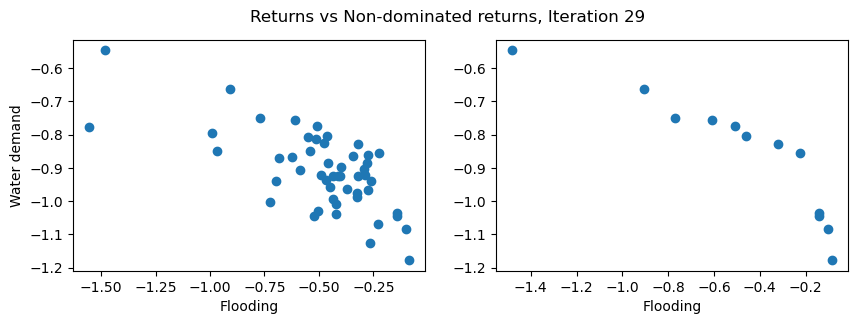

In [70]:
import time
import h5py
import matplotlib.pylab as plt
from IPython import display
from metrics import non_dominated, compute_hypervolume

logfile = h5py.File(logdir + 'log.h5', 'r')
returns = np.array(logfile['train/returns/ndarray'])
returns /= 100

for i in range(returns.shape[0]):
    current_returns = returns[i]
    current_nd = non_dominated(current_returns)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
    ax1.scatter(current_returns[:,0], current_returns[:,1])
    ax2.scatter(current_nd[:,0], current_nd[:,1])
    fig.suptitle(f'Returns vs Non-dominated returns, Iteration {i}')
    ax1.set_xlabel('Flooding')
    ax2.set_xlabel('Flooding')
    ax1.set_ylabel('Water demand')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(.1)
    if i < returns.shape[0]-1:
        plt.close()
display.clear_output(wait=False)

In [71]:
import pandas as pd
df = pd.DataFrame(data=current_returns, columns=['flooding', 'water-demand'])
df.to_csv('/tmp/returns.csv')
df = pd.DataFrame(data=current_nd, columns=['flooding', 'water-demand'])
df.to_csv('/tmp/returns_nd.csv')

### Hypervolume

Although the hypervolume metric was never used during training, we can compute it, to give us an impression of the evolution of the coverage set over time.

#### Definitions
**Coverage set**  
$CS(\Pi)$ is a subset of undominated set U which, $\forall u$ contains a policy with maximal scalarised value, i.e.,

$$
CS(\Pi) \subseteq U(\Pi) \land 
\left( \forall u, \exists \pi \in CS(\Pi), \forall \pi' \in \Pi :
u(\mathbf{V}^{\pi}) \ge u(\mathbf{V}^{\pi'}) \right).
$$

**HyperVolume**  
$$
HyperVolume(CS, \mathbf{V}_{ref}) =
\bigcup_{\pi \in CS} Volume(\mathbf{V}_{ref}, \mathbf{V}^{\pi}),
$$

which is the volume of the hypercube spanned by $\mathbf{V}_{ref}$ and $\mathbf{V}^{\pi}$ (the vector in the coverage set $CS$).

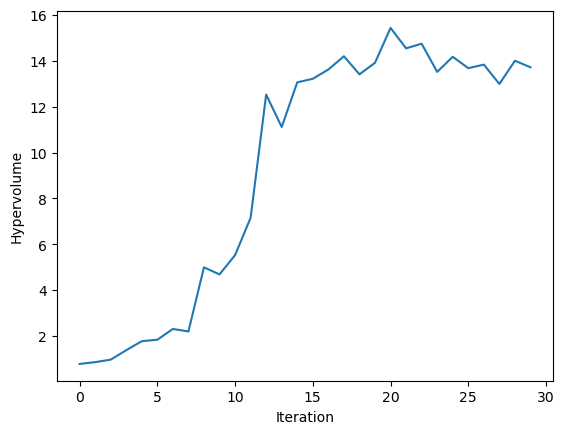

In [72]:
ref_point = np.min(returns.reshape(-1, 2), axis=0)
hypervolumes = [compute_hypervolume(ret, ref_point) for ret in returns]

plt.figure()
plt.plot(hypervolumes)
plt.xlabel('Iteration')
plt.ylabel('Hypervolume')
plt.show()


In [73]:
df = pd.DataFrame(data=hypervolumes, columns=['hypervolume'])
df.to_csv('/tmp/hypervolume.csv')

## Using Natural Evolution Strategies (NES) to optimize reward.

Instead of using a dedicated method (MONES) to discover diverse policies, we will use an outer loop method. In this particular case, we will use Natural Evolution Strategies (NES) as a single objective subroutine. This subroutine will be called a number of times, each time with different weights, hopefully resulting in different policies, that reach different points of the Coverage set.

NES will be called 30 times on our 2-objective problem with, for each iteration, a slight increase in weight `w_0`.

In [74]:
from wrappers.linear_scalarization import LinearScalarization

class VectorizeReward(gym.RewardWrapper):
    def reward(self, rew):
        return np.array([rew])

# make a single-objective version of the environment,
# using provided weights and linear scalarization
def make_ls_env(weights):
    env = make_env()
    env = LinearScalarization(env, weights)
    env = VectorizeReward(env)
    return env

# call NES with single-objective env
def make_so_subroutine(w):
    agent = MONES(
        lambda w=w: make_ls_env(w),
        Actor(1, 1, hidden=50),
        n_population=50,
        n_runs=10,
        indicator='single_objective',
        logdir=logdir + f'w_{w[0]}/'
    )
    return agent

In [75]:
if not SHOW_LOGS:
    # for each weight, call NES, use these weights to scalarize rewards in env
    for w_0 in np.linspace(0, 1, 30):
        print('='*10 + str(w_0) + '='*10)
        agent = make_so_subroutine(np.array([w_0, 1.-w_0]))
        agent.train(50)
        torch.save({'dist': agent.dist, 'policy': agent.policy}, agent.logdir + 'checkpoint.pt')
        display.clear_output(wait=False)

## Plotting the results

After 30 calls of our NES subroutine, we end up with 30 different policies. We evaluate each policy and plot the corresponding return.

Evaluating population: 100%|██████████████████████| 1/1 [00:00<00:00, 59.04it/s]


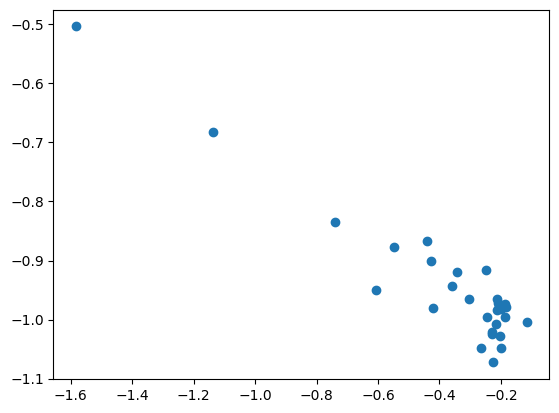

In [76]:
from pathlib import Path

tmp_agent = MONES(
    make_env,
    Actor(1, 1, hidden=50),
    n_population=1,
    n_runs=30,
    logdir=None
)

w_returns = []
torch.manual_seed(0)
np.random.seed(0)

plt.figure()
for wpath in Path(logdir).rglob('w_*/checkpoint.pt'):
    state_dict = torch.load(wpath, weights_only=False)
    tmp_agent.dist = state_dict['dist']
    tmp_agent.policy = state_dict['policy']
    pop, _ = tmp_agent.sample_population()
    r = tmp_agent.evaluate_population(make_env(), pop)
    r = np.mean(r.reshape(-1, 2).detach().numpy(), axis=0, keepdims=True)
    r /= 100
    w_returns.append(r)
w_returns = np.concatenate(w_returns, axis=0)
valid_w = w_returns[:, 0] > -5
w_returns = w_returns[valid_w]
plt.scatter(w_returns[:,0], w_returns[:,1])
plt.show()

## Comparing with MONES

Next, we will compare the policies found using MONES with those found by the outer loop method.

The first plot shows the different returns found using the MONES policies.

In the second plot, we show a side-by-side comparison of MONES policies (in orange) and NES policies with linear scalarization (in blue).

Evaluating population: 100%|████████████████████| 30/30 [00:00<00:00, 63.85it/s]


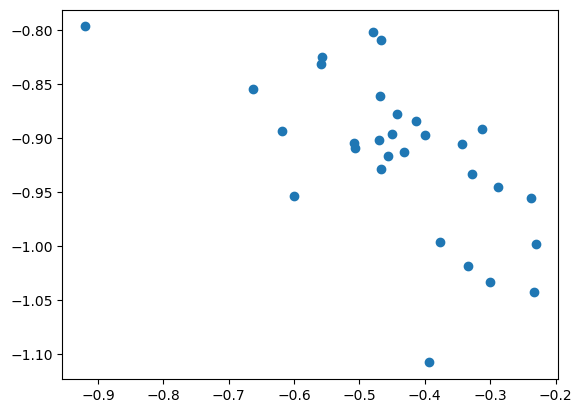

In [77]:
tmp_agent = MONES(
    make_env,
    Actor(1, 1, hidden=50),
    n_population=30,
    n_runs=30,
    logdir=None
)

state_dict = torch.load(logdir + 'checkpoint.pt', weights_only=False)
tmp_agent.dist = state_dict[' dist']
tmp_agent.policy = state_dict[' policy']

pop, _ = tmp_agent.sample_population()
r = tmp_agent.evaluate_population(make_env(), pop)
r /= 100
mo_returns = r[r[:, 0] > -5]
plt.figure()
plt.scatter(mo_returns[:,0], mo_returns[:,1])
plt.show()

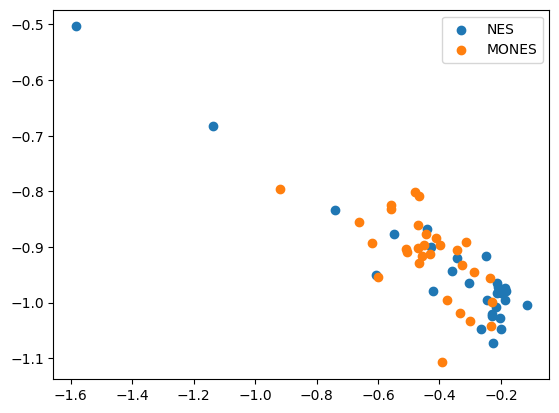

In [78]:
plt.figure()
plt.scatter(w_returns[:,0], w_returns[:,1], label='NES')
plt.scatter(mo_returns[:,0], mo_returns[:,1], label='MONES')
l_returns = returns[-1]

l_returns = l_returns[l_returns[:, 0] > -5]
plt.legend()

In [79]:
df = pd.DataFrame(data=w_returns, columns=['flooding', 'water-demand'])
df.to_csv('/tmp/returns-nes.csv')
df = pd.DataFrame(data=mo_returns, columns=['flooding', 'water-demand'])
df.to_csv('/tmp/returns-mones.csv')

### Definitions
**Convex coverage set**  
A convex hull (CH) is a set of policies which maximize weighted sum of objectives (for weight vector $\mathbf{w}$). A convex coverage set (CCS) if it is a subset of a convex hull if $\forall \mathbf{w}$ it contains policy with max. linearly scalarised value, i.e., 

$$
CCS(\Pi) \subseteq CH(\Pi)
\land
\left(
\forall \mathbf{w},\,
\exists \pi \in CCS(\Pi),\,
\forall \pi' \in \Pi :
\mathbf{w}^\top \mathbf{V}^{\pi} \ge \mathbf{w}^\top \mathbf{V}^{\pi'}
\right).
$$

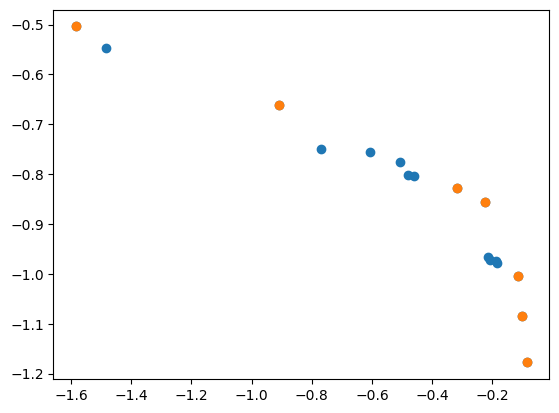

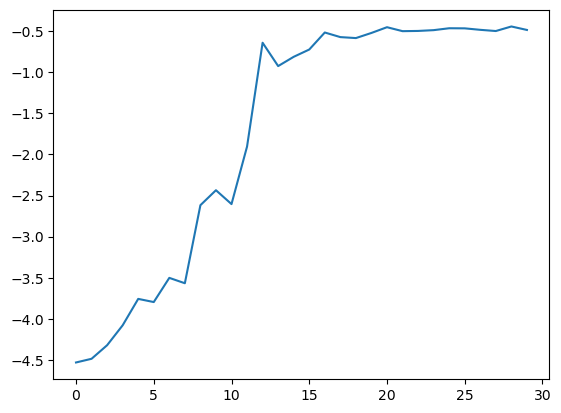

In [80]:
# get the overall optimal returns over all experiments
optimal_returns = np.concatenate((w_returns, mo_returns, returns[-1]), axis=0)
optimal_returns = non_dominated(optimal_returns)

# for all possible weights, compute the utility wrt all optimal returns
all_weights = np.linspace(0, 1, 1000)
all_weights = np.stack((all_weights, 1-all_weights), axis=1)
all_utilities = (all_weights[:, None, :]*optimal_returns[None, :, :]).sum(-1)

# for linear weights, only the points on the CCS will offer the highest utility
convex_returns = optimal_returns[np.unique(all_utilities.argmax(axis=1))]
# plot non-dominated points over all experiments,
# plot points on CCS separately (only these result in highest utility)
plt.figure()
plt.scatter(optimal_returns[:, 0], optimal_returns[:, 1])
plt.scatter(convex_returns[:, 0], convex_returns[:, 1])

# compare max utilities with utility gotten from MONES for each training iteration
eums = []
for i in range(returns.shape[0]):
    current_returns = returns[i]
    # get best utility for each return of current training iteration,
    # wrt linear scalarization
    mo_utilities = (all_weights[:, None, :]*current_returns[None, :, :]).sum(-1)
    eum = mo_utilities.max(axis=1)
    eums.append(eum.mean())
plt.figure()
plt.plot(eums)

### Results
The MONES PF approximation (scatter plot, orange) is less crowded and has more points than the same for NES (scatter plot, blue).

In [81]:
df = pd.DataFrame(data=eums, columns=['eum'])
df.to_csv('/tmp/eum-mones.csv')

**Note**: All definitions are from the original paper [Conor F. Hayes et. al](https://arxiv.org/pdf/2103.09568)

## MO-DQN on the Dam environment



In [82]:
import gymnasium as gym

from learners.mo_dqn.mo_dqn_policy import MODQN
from learners.mo_dqn.mo_dqn_trainer import ReplayBuffer, MODQNTrainer

Reset environment

In [83]:
class ResetInfoWrapper(gym.Wrapper):
    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        return obs, {}
        
env_modqn = ResetInfoWrapper(make_env())

num_actions = env_modqn.action_space.n
num_obs = env_modqn.observation_space.shape[0]
num_objectives = env_modqn.unwrapped.nO 

Train Mo-DQN on Dam Environment (Equal preference weights)

In [84]:
utility_weights = [0.5, 0.5]

policy_modqn = MODQN(
    utility_fn=utility_weights,
    num_actions=num_actions,
    num_obs=num_obs,
    num_objectives=num_objectives,
    layer_sizes=[64, 64], 
)

replay_buffer_modqn = ReplayBuffer(max_size=50_000)

trainer_modqn = MODQNTrainer(
    policy=policy_modqn,
    lr=1e-3,
    gamma=0.99,
    batch_size=64,
    replay_buffer=replay_buffer_modqn,
    env=env_modqn,
    target_update_freq=500,
    epsilon_decay=0.999,   
    updates_per_episode=1,
)

trainer_modqn.train(
    num_episodes=500,
    ep_len=100,
    warmup_episodes=10,
    warmup_ep_len=100,
    epsilon_start=1.0,
    epsilon_end=0.05,
    log_freq=50,
)

------------------------------------------------------------
Starting MODQN training for 500 episodes...
------------------------------------------------------------
Filling buffer
Buffer filled
------------------------------------------------------------
Beginning main training loop
Episode 50/500 | Return: -5030.02 | Length: 100 | Loss: 142.6452 | Epsilon: 0.951 | 
  MO Return: [-9069.23457875  -990.80227297]
Episode 100/500 | Return: -5052.74 | Length: 100 | Loss: 210.5103 | Epsilon: 0.905 | 
  MO Return: [-8951.3111503 -1154.174561 ]
Episode 150/500 | Return: -5067.86 | Length: 100 | Loss: 235.7815 | Epsilon: 0.861 | 
  MO Return: [-8998.08404196 -1137.64254406]
Episode 200/500 | Return: -5043.76 | Length: 100 | Loss: 244.1303 | Epsilon: 0.819 | 
  MO Return: [-8837.61466074 -1249.91067384]
Episode 250/500 | Return: -5036.50 | Length: 100 | Loss: 453.6373 | Epsilon: 0.779 | 
  MO Return: [-8924.93405187 -1148.06321477]
Episode 300/500 | Return: -5050.82 | Length: 100 | Loss: 364.44

Evaluate Mo-DQN and Comparison between EUM and MONES 

In [85]:
import numpy as np

def evaluate_policy(env, policy, num_episodes=30, ep_len=100):
    returns = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        total = np.zeros(policy.num_objectives)
        for t in range(ep_len):
            action = policy.act(state, epsilon=0.0) 
            next_state, reward, terminated, truncated, info = env.step(action)
            total += np.array(reward)
            state = next_state
            if terminated or truncated:
                break
        returns.append(total)
    return np.array(returns)  

modqn_returns = evaluate_policy(env_modqn, policy_modqn, num_episodes=30, ep_len=100)
modqn_returns = modqn_returns / 100.0

mo_dqn_utilities = (all_weights[:, None, :] * modqn_returns[None, :, :]).sum(-1)

modqn_eum = mo_dqn_utilities.max(axis=1).mean()

print("MONES final EUM:", eums[-1])
print("MO-DQN EUM:", modqn_eum)

MONES final EUM: -0.4860578497690004
MO-DQN EUM: -48.99059579976458


Plotting actions vs utility weights for the Dam environment

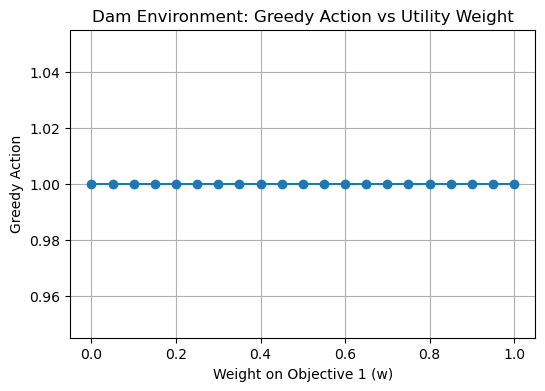

In [86]:
import matplotlib.pyplot as plt

state, _ = env_modqn.reset(seed=0)
for _ in range(30):  
    a = env_modqn.action_space.sample()
    state, reward, terminated, truncated, info = env_modqn.step(a)
    if terminated or truncated:
        break


ws = np.linspace(0.0, 1.0, 21) 
actions = []

for w in ws:

    tmp_policy = MODQN(
        utility_fn=[w, 1 - w],
        num_actions=num_actions,
        num_obs=num_obs,
        num_objectives=num_objectives,
        layer_sizes=[64, 64],
    )
    tmp_policy.model.load_state_dict(policy_modqn.model.state_dict())

    a = tmp_policy.act(state, epsilon=0.0)
    actions.append(a)

plt.figure(figsize=(6, 4))
plt.plot(ws, actions, marker='o')
plt.xlabel("Weight on Objective 1 (w)")
plt.ylabel("Greedy Action")
plt.title("Dam Environment: Greedy Action vs Utility Weight")
plt.grid(True)
plt.show()


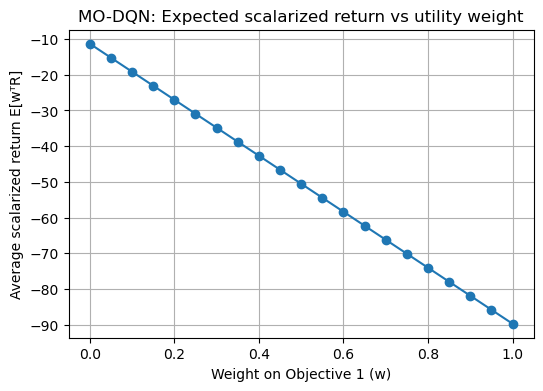

In [87]:
import numpy as np
import matplotlib.pyplot as plt

ws = np.linspace(0.0, 1.0, 21)

avg_utils = []

for w in ws:
    w_vec = np.array([w, 1 - w]) 
    u = (modqn_returns * w_vec).sum(axis=1) 
    avg_utils.append(u.mean())

plt.figure(figsize=(6, 4))
plt.plot(ws, avg_utils, marker='o')
plt.xlabel("Weight on Objective 1 (w)")
plt.ylabel("Average scalarized return E[wᵀR]")
plt.title("MO-DQN: Expected scalarized return vs utility weight")
plt.grid(True)
plt.show()


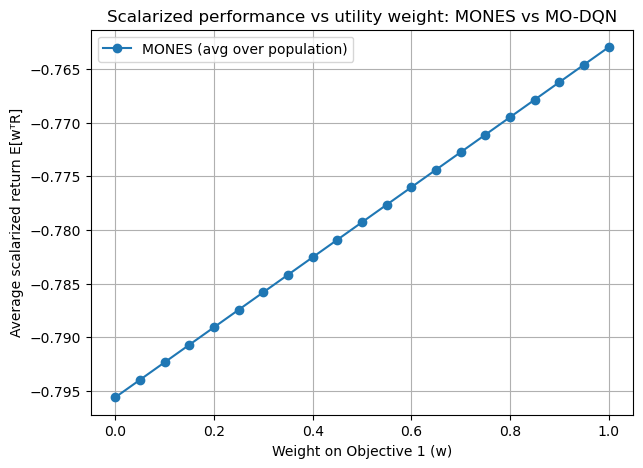

In [88]:
plt.figure(figsize=(7, 5))

plt.plot(ws, avg_utils_mones, marker='o', label="MONES (avg over population)")

mones_min = min(avg_utils_mones)
mones_max = max(avg_utils_mones)
padding = 0.05 * (mones_max - mones_min if mones_max > mones_min else 1.0)
plt.ylim(mones_min - padding, mones_max + padding)

plt.xlabel("Weight on Objective 1 (w)")
plt.ylabel("Average scalarized return E[wᵀR]")
plt.title("Scalarized performance vs utility weight: MONES vs MO-DQN")
plt.grid(True)
plt.legend()
plt.show()
